In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
def load_data():
    """load data."""
    data = np.loadtxt("dataEx3.csv", delimiter=",", skiprows=1, unpack=True)
    x = data[0]
    y = data[1]
    return x, y

def compute_mse(y, tx, w):
    """compute the loss by mse."""
    e = y - tx.dot(w)
    mse = e.dot(e) / (2 * len(e))
    return mse

def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    aI = 2 * tx.shape[0] * lambda_ * np.identity(tx.shape[1])
    a = tx.T.dot(tx) + aI
    b = tx.T.dot(y)
    return np.linalg.solve(a, b)

def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    poly = np.ones((len(x), 1))
    for deg in range(1, degree+1):
        poly = np.c_[poly, np.power(x, deg)]
    return poly

def least_squares(y, tx):
    """calculate the least squares."""
    a = tx.T.dot(tx)
    b = tx.T.dot(y)
    return np.linalg.solve(a, b)

def split_data(x, y, ratio, seed=1):
    """split the dataset based on the split ratio."""
    # set seed
    np.random.seed(seed)
    # generate random indices
    num_row = len(y)
    indices = np.random.permutation(num_row)
    index_split = int(np.floor(ratio * num_row))
    index_tr = indices[: index_split]
    index_te = indices[index_split:]
    # create split
    x_tr = x[index_tr]
    x_te = x[index_te]
    y_tr = y[index_tr]
    y_te = y[index_te]
    return x_tr, x_te, y_tr, y_te

# Cross-Validation and Bias-Variance decomposition
Implementing 4-fold cross-validation below:

## Cross-Validation
**TODO What does the figure say?**

In [3]:
# load dataset
x, y = load_data()

In [4]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    
    # get k'th subgroup in test, others in train
    te_indice = k_indices[k]
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    y_te = y[te_indice]
    y_tr = y[tr_indice]
    x_te = x[te_indice]
    x_tr = x[tr_indice]

    # form data with polynomial degree
    tx_tr = build_poly(x_tr, degree)
    tx_te = build_poly(x_te, degree)

    # ridge regression
    w = ridge_regression(y_tr, tx_tr, lambda_)
    # calculate the loss for train and test data
    loss_tr = np.sqrt(2 * compute_mse(y_tr, tx_tr, w))
    loss_te = np.sqrt(2 * compute_mse(y_te, tx_te, w))
    return loss_tr, loss_te,w

Polynomial degree:7


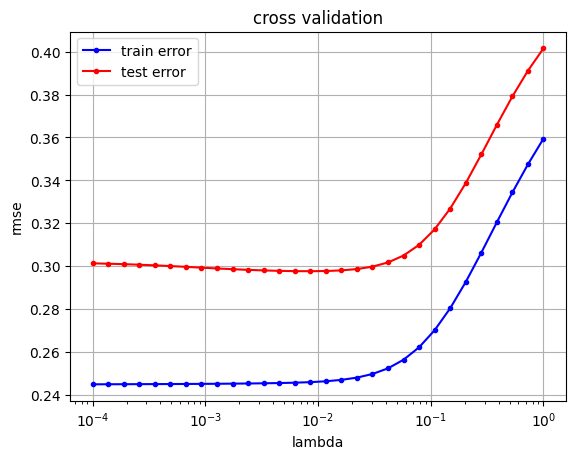

In [5]:
from plots import cross_validation_visualization

def cross_validation_demo(degree:int=7,
                          k_fold:int=4):
    # seed for reproducibility
    seed = 12

    print(f"Polynomial degree:{degree}")
    
    # lambda search space
    lambdas = np.logspace(-4, 0, 30)

    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)

    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []

    # cross validation
    for lambda_ in lambdas:
        rmse_tr_tmp = []
        rmse_te_tmp = []
        for k in range(k_fold):
            loss_tr, loss_te,_ = cross_validation(y, x, k_indices, k, lambda_, degree)
            rmse_tr_tmp.append(loss_tr)
            rmse_te_tmp.append(loss_te)
        rmse_tr.append(np.mean(rmse_tr_tmp))
        rmse_te.append(np.mean(rmse_te_tmp))

    cross_validation_visualization(lambdas, rmse_tr, rmse_te)

cross_validation_demo()

### Selection of the best model among various degrees:
**TODO: why do we need to find the best lambda for each degree?**

In [6]:
def best_degree_selection(degrees, k_fold, lambdas, seed = 1):
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    
    #for each degree, we compute the best lambdas and the associated rmse
    best_lambdas = []
    best_rmses = []
    #vary degree
    for degree in degrees:
        # cross validation
        rmse_te = []
        for lambda_ in lambdas:
            rmse_te_tmp = []
            for k in range(k_fold):
                _, loss_te,_ = cross_validation(y, x, k_indices, k, lambda_, degree)
                rmse_te_tmp.append(loss_te)
            rmse_te.append(np.mean(rmse_te_tmp)) # appending the mean over test
        
        ind_lambda_opt = np.argmin(rmse_te)
        best_lambdas.append(lambdas[ind_lambda_opt])
        best_rmses.append(rmse_te[ind_lambda_opt])
        
    ind_best_degree =  np.argmin(best_rmses)      
        
    return degrees[ind_best_degree]


In [7]:
# example
best_degree_selection(degrees=np.arange(2,11), 
                      k_fold=4, 
                      lambdas=np.logspace(-4, 0, 30))

7

Box-plot of the RMSE using the cross-validation:

Lambdas: {1: 0.0001, 2: 0.0001623776739188721, 3: 0.00026366508987303583, 4: 0.00042813323987193956, 5: 0.0006951927961775605, 6: 0.0011288378916846883, 7: 0.0018329807108324356, 8: 0.002976351441631319, 9: 0.004832930238571752, 10: 0.007847599703514606, 11: 0.012742749857031334, 12: 0.0206913808111479, 13: 0.03359818286283781, 14: 0.05455594781168514, 15: 0.08858667904100823, 16: 0.14384498882876628, 17: 0.23357214690901212, 18: 0.3792690190732246, 19: 0.615848211066026, 20: 1.0}


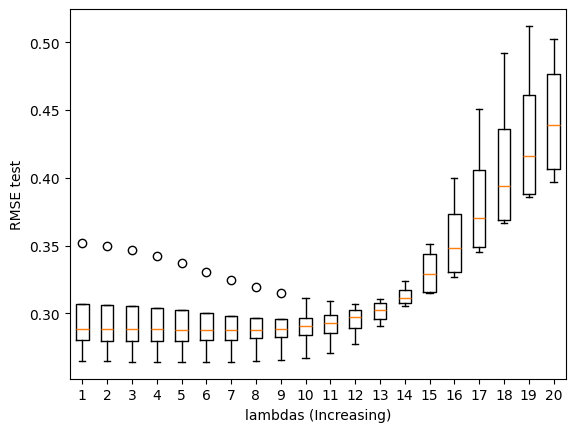

In [8]:
def extended_cross_validation_demo():
    seed = 1
    degree = 7
    k_fold = 4
    lambdas = np.logspace(-4, 0, 20)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    variances = []
    # cross validation
    for lambda_ in lambdas:
        rmse_tr_tmp = []
        rmse_te_tmp = []
        for k in range(k_fold):
            loss_tr, loss_te,_ = cross_validation(y, x, k_indices, k, lambda_, degree)
            rmse_tr_tmp.append(loss_tr)
            rmse_te_tmp.append(loss_te)
        rmse_tr.append(rmse_tr_tmp)
        rmse_te.append(rmse_te_tmp)
        variances.append(loss_te)

    plt.boxplot(rmse_te)
    plt.ylabel('RMSE test')
    plt.xlabel('lambdas (Increasing)')
    # plt.xticks(ticks=range(len(lambdas)))
    
    print('Lambdas:',dict(zip(range(1,1+len(lambdas)),lambdas)))
    

extended_cross_validation_demo()

## Bias-Variance Decomposition
Visualize bias-variance trade-off by implementing the function `bias_variance_demo()`.

**TODO: What do you observe? How do you make sense of it?**

c:\Users\fadel\OneDrive\Bureau\Projet Delcaux AI-DT Consulting\Cours - ML-DL\ML-tutorial\Exercises\Week 2\UnderstandingCrossVal\plots.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(
c:\Users\fadel\OneDrive\Bureau\Projet Delcaux AI-DT Consulting\Cours - ML-DL\ML-tutorial\Exercises\Week 2\UnderstandingCrossVal\plots.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(


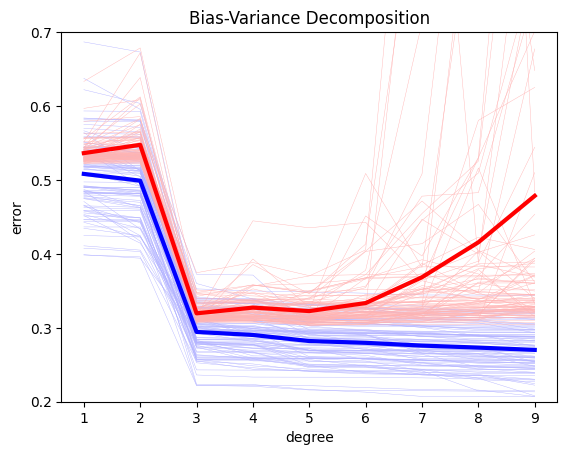

In [9]:
from plots import bias_variance_decomposition_visualization

def bias_variance_demo():
    """The entry."""
    # define parameters
    seeds = range(100)
    num_data = 10000
    ratio_train = 0.005
    degrees = range(1, 10)
    
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        # split data with a specific seed
        x_tr, x_te, y_tr, y_te = split_data(x, y, ratio_train, seed)
        
        for index_degree, degree in enumerate(degrees):
            # form polynomial data
            tx_tr = build_poly(x_tr, degree)
            tx_te = build_poly(x_te, degree)
            # least square
            w = least_squares(y_tr, tx_tr)
            # calculate the rmse for train and test
            rmse_tr[index_seed, index_degree] = np.sqrt(2 * compute_mse(y_tr, tx_tr, w))
            rmse_te[index_seed, index_degree] = np.sqrt(2 * compute_mse(y_te, tx_te, w))

    bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)
bias_variance_demo()

Distribution of the test error for Least square (i.e. linear regression)

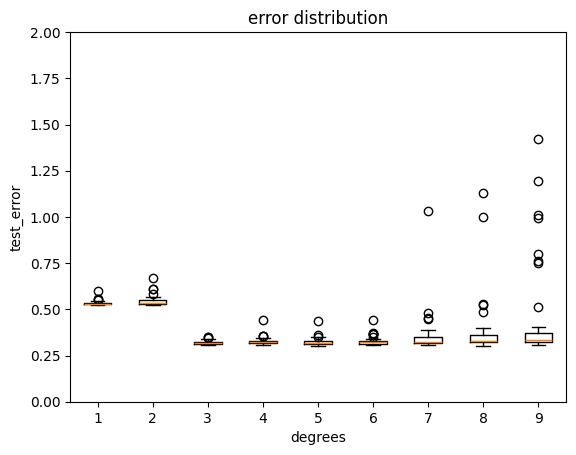

In [12]:
def test_error_distribution_demo():
    """The entry."""
    # define parameters
    seeds = range(50)
    num_data = 10000
    ratio_train = 0.005
    degrees = range(1, 10)
    
    # define list to store the variable
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        # split data with a specific seed
        x_tr, x_te, y_tr, y_te = split_data(x, y, ratio_train, seed)
        
        for index_degree, degree in enumerate(degrees):
            # form polynomial data
            tx_tr = build_poly(x_tr, degree)
            tx_te = build_poly(x_te, degree)
            # least square
            w = least_squares(y_tr, tx_tr)
            # calculate the rmse for test
            rmse_te[index_seed, index_degree] = np.sqrt(2 * compute_mse(y_te, tx_te, w))

    plt.boxplot(rmse_te)
    plt.title("error distribution")
    plt.xlabel("degrees")
    plt.ylabel("test_error")
    plt.ylim(0,2)
test_error_distribution_demo()

For Ridge regression:

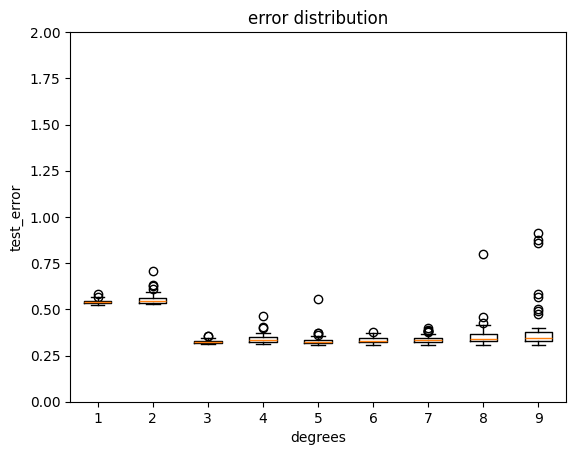

In [13]:
def test_error_distribution_demo():
    """The entry."""
    # define parameters
    seeds = range(50)
    num_data = 10000
    lambdas = np.logspace(-4, 0, 30)

    ratio_train = 0.005
    degrees = range(1, 10)
    
    # define list to store the variable
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        # split data with a specific seed
        x_tr, x_te, y_tr, y_te = split_data(x, y, ratio_train, seed)
        
        k_fold = 4
        k_indices = build_k_indices(y_tr, k_fold, 1)
        
        for index_degree, degree in enumerate(degrees):
            # form polynomial data
            tx_tr = build_poly(x_tr, degree)
            tx_te = build_poly(x_te, degree)
            
            
            # selecting best lambda
            rmse_te_tmp = []
            ws = []
            for lambda_ in lambdas:
                rmse_te_tmp2 = []
                ws_tmp = []
                for k in range(k_fold):
                    _, loss_te, w = cross_validation(y_tr, x_tr, k_indices, k, lambda_, degree)
                    ws_tmp.append(w)
                    rmse_te_tmp2.append(loss_te)
                rmse_te_tmp.append(np.mean(rmse_te_tmp2))
                ws.append(ws_tmp)
            ind_lambda_opt = np.argmin(rmse_te_tmp)
            ws_opt = ws[ind_lambda_opt]
            lambda_opt = lambdas[ind_lambda_opt]
            
            # calculate the rmse for test
            rmse_te[index_seed, index_degree] =  np.mean([np.sqrt(2 * compute_mse(y_te, tx_te, w)) for w in ws_opt])

    plt.boxplot(rmse_te)
    plt.title("error distribution")
    plt.xlabel("degrees")
    plt.ylabel("test_error")
    plt.ylim(0,2)
test_error_distribution_demo()